数据来源：https://tianchi.aliyun.com/dataset/649

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display

In [30]:
data = pd.read_csv("C:/Users/zheji/Desktop/User Behavior Analysis/dataset/UserBehavior.csv")

In [3]:
data.columns = ['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp']

In [4]:
data.head()

,user_id,item_id,category_id,behavior_type,timestamp
0,1,2333346,2520771,pv,1511561733
1,1,2576651,149192,pv,1511572885
2,1,3830808,4181361,pv,1511593493
3,1,4365585,2520377,pv,1511596146
4,1,4606018,2735466,pv,1511616481


In [6]:
data.isnull().sum()

user_id          0
item_id          0
category_id      0
behavior_type    0
timestamp        0
dtype: int64

In [5]:
data.describe()

,user_id,item_id,category_id,timestamp
count,1.001508e+08,1.001508e+08,1.001508e+08,1.001508e+08
mean,5.069431e+05,2.579775e+06,2.696380e+06,1.511951e+09
std,2.940605e+05,1.488056e+06,1.463155e+06,5.528006e+06
min,1.000000e+00,1.000000e+00,8.000000e+01,-2.134949e+09
25%,2.524290e+05,1.295225e+06,1.320293e+06,1.511762e+09
50%,5.040150e+05,2.580735e+06,2.671397e+06,1.511965e+09
75%,7.609490e+05,3.862042e+06,4.145813e+06,1.512179e+09
max,1.018011e+06,5.163070e+06,5.162429e+06,2.122867e+09


注意到时间戳最小值为-2,134,949,000,转换成北京时间约为1902/05/18。最大值为2,122,867,000，转换成北京时间约为2027/03/14。在数据集的描述中，范围为2017/11/25到2017/12/03。之后我们会这个范围外的数据排除。

In [13]:
data['behavior_type'].value_counts()

behavior_type
pv      89716263
cart     5530446
fav      2888258
buy      2015839
Name: count, dtype: int64

behavior_type 解释: 

**pv** - 商品详情页的浏览量，相当于用户点击查看商品。


**cart** - 将商品加入购物车。


**fav** -   收藏商品。


**buy** -  购买商品。

连接到sqlite并创建表格

In [2]:
conn = sqlite3.connect('user_behavior.db')
cursor = conn.cursor()

In [ ]:
cursor.execute('DROP TABLE IF EXISTS user_behavior')
cursor.execute('''
    CREATE TABLE user_behavior (
    user_id INTEGER,
    item_id INTEGER,
    category_id INTEGER,
    behavior_type TEXT,
    timestamp INTEGER
)
''')
conn.commit()

In [19]:
cursor.executemany("""insert into user_behavior values (?,?,?,?,?)""", data.values.tolist())
conn.commit()

基于这个数据集，我们可以解决以下几个核心业务问题：

**问题1: 短期用户留存模式分析**

问题: "在9天的时间窗口内，用户的短期留存模式如何？第1、2、3天的回访率有何趋势？"

**问题2: 用户行为转化漏斗分析**

问题: "从浏览到购买，每个阶段的转化率怎么样？"

**问题3：峰谷时段的转化效率评估**

问题："在一天的24小时时间窗口内，用户的流量峰值和谷值分别出现在哪个时段？从峰值到谷值，PV到购买的转化率（PV to Buy CR）有何趋势变化？"

**问题4: RFM 重要用户分析**

问题: "用户的画像是哪些？"

**问题5: 商品类别表现分析**

业务问题: "哪些商品类别拥有最高的用户参与度和复购率？应该如何优化商品推荐策略？"

# 问题1：

In [15]:
cursor.execute('DROP VIEW IF EXISTS user_behavior_data')
cursor.execute("""create view user_behavior_data as
               select 
               user_id, item_id, category_id, behavior_type,
               datetime(timestamp, 'unixepoch', '+8 hours') as activity_time -- 将unix时间戳转换为北京时间
               from user_behavior
               where datetime(timestamp, 'unixepoch', '+8 hours') BETWEEN '2017-11-25 00:00:00' AND '2017-12-03 23:59:59'""")

In [28]:
filtered_check = """
SELECT 
    COUNT(*) as total_records,
    MIN(activity_time) as min_time,
    MAX(activity_time) as max_time,
    COUNT(DISTINCT user_id) as unique_users
FROM user_behavior_data
"""
filtered_stats = pd.read_sql_query(filtered_check, conn)
filtered_stats

,total_records,min_time,max_time,unique_users
0,100095230,2017-11-25 00:00:00,2017-12-03 23:59:59,987991


In [31]:
len(data) - filtered_stats['total_records'][0]

55576

我们总共筛除了55,576数据。

In [32]:
unfiltered_check = """ With
user_cohort as(
    Select user_id, date(min(activity_time)) as cohort_date
    from user_behavior_data
    group by user_id),
daily_activity as(
    Select ubd.user_id, DATE(ubd.activity_time) as activity_date, uc.cohort_date,
    Cast(julianday(ubd.activity_time) - julianday(uc.cohort_date) as integer) as day_difference
    From user_behavior_data ubd
    Join user_cohort uc on ubd.user_id = uc.user_id)
Select
    cohort_date, count(distinct user_id) as cohort_size, 
    round(100 * count(distinct case when day_difference = 1 then user_id end) / count(distinct user_id),2) as day_1_retention,
    round(100 * count(distinct case when day_difference = 2 then user_id end) / count(distinct user_id),2) as day_2_retention,
    round(100 * count(distinct case when day_difference = 3 then user_id end) / count(distinct user_id),2) as day_3_retention
    From daily_activity
    Group by cohort_date
    Order by cohort_date
"""
retention_profile = pd.read_sql_query(unfiltered_check, conn)
retention_profile

,cohort_date,cohort_size,day_1_retention,day_2_retention,day_3_retention
0,2017-11-25,706641,78.0,76.0,75.0
1,2017-11-26,158188,65.0,64.0,65.0
2,2017-11-27,63825,61.0,62.0,64.0
3,2017-11-28,31331,61.0,63.0,66.0
4,2017-11-29,17931,69.0,71.0,96.0
5,2017-11-30,9801,94.0,95.0,95.0
6,2017-12-01,255,90.0,92.0,0.0
7,2017-12-02,18,72.0,0.0,0.0
8,2017-12-03,1,0.0,0.0,0.0


我们注意到2017-12-01到2017-12-03的**同期群规模**的数量非常小相对于整体的数据量(100,095,230)，没有什么统计意义。

注意12-01到12-03的同期群规模（也可以算是新客户数）相比12月前非常小，我们需要知道12月的用户组成。

In [33]:
retention_profile_filtered = retention_profile[:-3]
retention_profile_filtered

,cohort_date,cohort_size,day_1_retention,day_2_retention,day_3_retention
0,2017-11-25,706641,78.0,76.0,75.0
1,2017-11-26,158188,65.0,64.0,65.0
2,2017-11-27,63825,61.0,62.0,64.0
3,2017-11-28,31331,61.0,63.0,66.0
4,2017-11-29,17931,69.0,71.0,96.0
5,2017-11-30,9801,94.0,95.0,95.0


12/01-12/03分析：

In [34]:
dec_user_analysis = """
WITH dec_users AS (
    SELECT DISTINCT user_id
    FROM user_behavior_data
    WHERE DATE(activity_time) IN ('2017-12-01', '2017-12-02', '2017-12-03')
),
user_first_activity AS (
    SELECT 
        du.user_id,
        MIN(ubd.activity_time) as first_activity
    FROM dec_users du
    JOIN user_behavior_data ubd ON du.user_id = ubd.user_id
    GROUP BY du.user_id
)
SELECT 
    COUNT(*) as total_dec_users,
    SUM(CASE WHEN DATE(first_activity) < '2017-12-01' THEN 1 ELSE 0 END) as existing_users,
    SUM(CASE WHEN DATE(first_activity) >= '2017-12-01' THEN 1 ELSE 0 END) as new_users
FROM user_first_activity
"""

In [35]:
dec_user_stats = pd.read_sql_query(dec_user_analysis, conn)
dec_user_stats

,total_dec_users,existing_users,new_users
0,987399,987125,274


In [42]:
retention_profile.to_csv('retention_profile_data.csv')

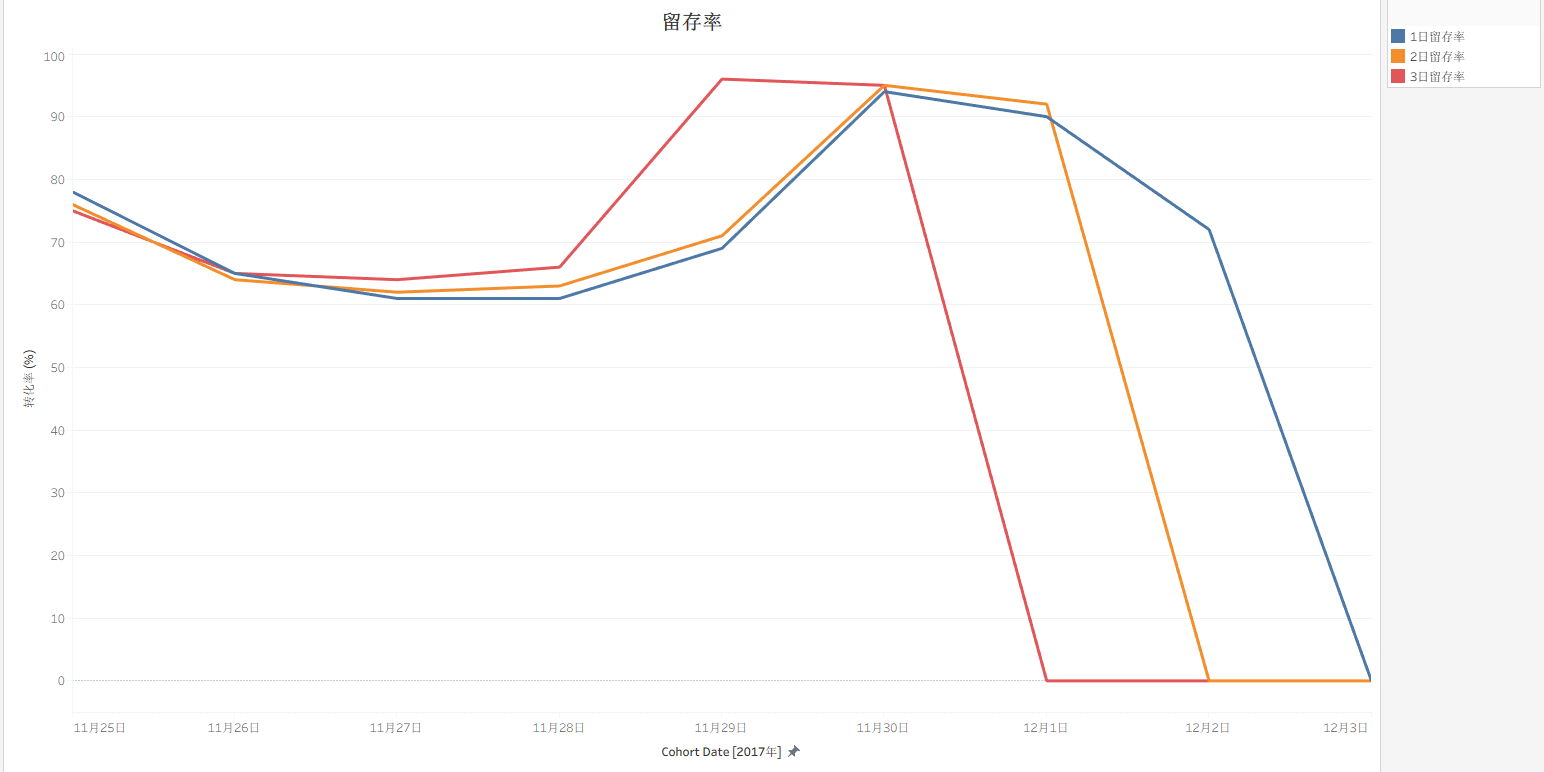

In [12]:
display(Image(filename='问题1.png'))

**结论：**

从用户数据来看，11月35到30日的新用户规模较大，留存情况整体稳定，第1天留存在 61% 到 78% 之间，第3天仍保持在 64% 到 75%。说明这一阶段的新用户活跃度较高，平台用户增长表现良好。

进入12月后，新用户数量急剧下降。根据统计，12月共有 987,399 名活跃用户，其中 老用户占比高达 99.97%（987,125 人），新用户仅 274 人。这说明12月的活跃主要来自以往的老用户，而新增用户几乎可以忽略不计。与此同时，12月初的留存数据出现了较大的波动，这种情况多半与样本量过小以及双十二活动期间的异常访问有关。结合背景来看，12月1日至8日是淘宝“双十二”活动的预热期，用户访问量主要集中在老用户加购和活动浏览上，而不是新用户注册。

**建议：**
1. 维持11月下旬的拉新策略：这段时间的新用户质量较高，建议复盘当时的推广渠道和营销内容，找到高质量用户来源，并在后续活动中重点延续或加强。
2. 双十二期间平台流量高，但新用户数低，说明活动对新客吸引力不足。建议在活动主会场和支付页面增加针对新用户的引导与优惠，如“新人专享红包”或“首次购买奖励”。
3. 建议跟踪12月被重新激活的老用户在1月、2月的活跃情况，评估活动带来的长期价值，为明年的活动策略提供依据。


# 问题2:

行为转化:<br><br>
浏览(pv) → 收藏(fav) + 加购(cart) → 购买(buy) <br><br>
收藏与加购没有直接的因果导向关系，我们把他们归为一类，可以称他们为兴趣行为.

In [38]:
query = """WITH user_behavior_profile AS (
    SELECT 
        behavior_type,
        sum(CASE WHEN behavior_type = 'pv' THEN 1 ELSE 0 END) AS pv_count,
        sum(CASE WHEN behavior_type in ('fav', 'cart') THEN 1 ELSE 0 END) AS fav_cart_count,
        sum(CASE WHEN behavior_type = 'buy' THEN 1 ELSE 0 END) AS buy_count
    FROM user_behavior_data
)
SELECT
    pv_count, fav_cart_count, buy_count,
    round(100 * fav_cart_count/pv_count) as 'conversion between fav/cart and pv',
    round(100 * buy_count/fav_cart_count) as 'conversion between fav/cart and buy',
    round(100 * buy_count/pv_count) as 'conversion between pv and buy'
FROM user_behavior_profile
"""
conversion_funnel = pd.read_sql_query(query, conn)
conversion_funnel

,pv_count,fav_cart_count,buy_count,conversion between fav/cart and pv,conversion between fav/cart and buy,conversion between pv and buy
0,89660687,8418704,2015839,9.0,23.0,2.0


In [39]:
conversion_funnel.to_csv('conversion_funnel_data.csv')

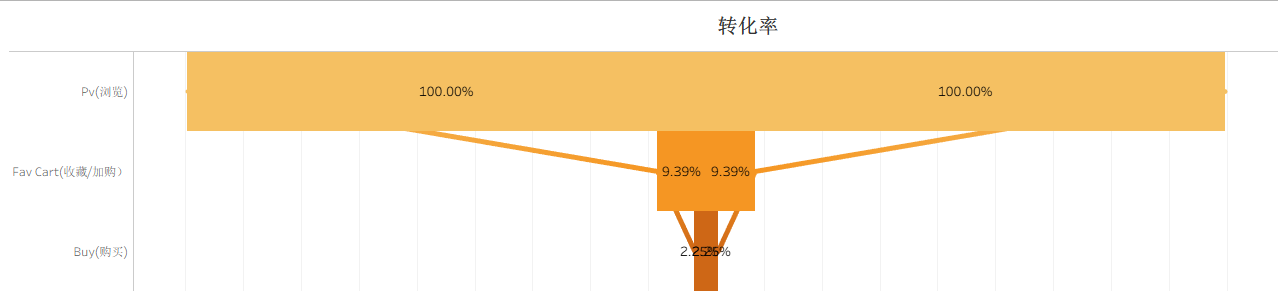

In [11]:
display(Image(filename='问题2.png'))

整体转化率（浏览 → 购买）为 2%，说明平均每 100 次浏览行为中仅产生 2 次购买行为。<br><br>
兴趣行为（收藏或加购）到购买的转化率为 23%，表明一旦用户对商品表现出兴趣，每 100 次兴趣行为中有 23 次最终转化为购买。<br><br>
然而，只有 9% 的浏览行为能够转化为兴趣行为，说明多数用户虽然产生浏览，但未进一步表达购买意愿。可能是因为用户在加购后比价，而发现更优选择。

**建议**：
当前购买转化的主要瓶颈在于激发兴趣阶段，若能有效提升浏览到收藏/加购的比例，将显著放大整体购买转化效果。
可以考虑优化商品详情页的内容，提供店铺收藏优惠卷等。<br><br>
针对购物车中留存超过 $24 \sim 48$ 小时的用户，推送 个性化的限时优惠券 或 限时免运费 提醒。打破价格犹豫，刺激用户立即下单。

# 问题三：

In [ ]:
query_3 = """
SELECT
    CAST(strftime('%H', activity_time) AS INTEGER) AS hours,
    CASE
        When strftime('%w', activity_time) between '1' AND '5' THEN 'Weekday'
        ELSE 'Weekend'
    End as week_of_day,
    sum(case when behavior_type = 'pv' THEN 1 ELSE 0 END) AS total_pv,
    sum(case when behavior_type = 'buy' THEN 1 ELSE 0 END) AS total_buy,
    round(100.0 * sum(case when behavior_type = 'buy' THEN 1 ELSE 0 END) / sum(case when behavior_type = 'pv' THEN 1 ELSE 0 END), 2) as buy_to_pv_ratio
FROM user_behavior_data
GROUP BY hours, week_of_day
ORDER BY hours, week_of_day
"""
df = pd.read_sql_query(query_3, conn)
df

,hours,week_of_day,total_pv,total_buy,buy_to_pv_ratio
0,0,Weekday,1503565,32770,2.18
1,0,Weekend,1553371,25006,1.61
2,1,Weekday,682363,11928,1.75
3,1,Weekend,739309,11241,1.52
4,2,Weekday,377151,6182,1.64
5,2,Weekend,392118,5830,1.49
6,3,Weekday,266335,4212,1.58
7,3,Weekend,258657,3814,1.47
8,4,Weekday,233239,3579,1.53
9,4,Weekend,216389,3169,1.46


In [10]:
df.to_csv('hourly_behavior_analysis.csv')

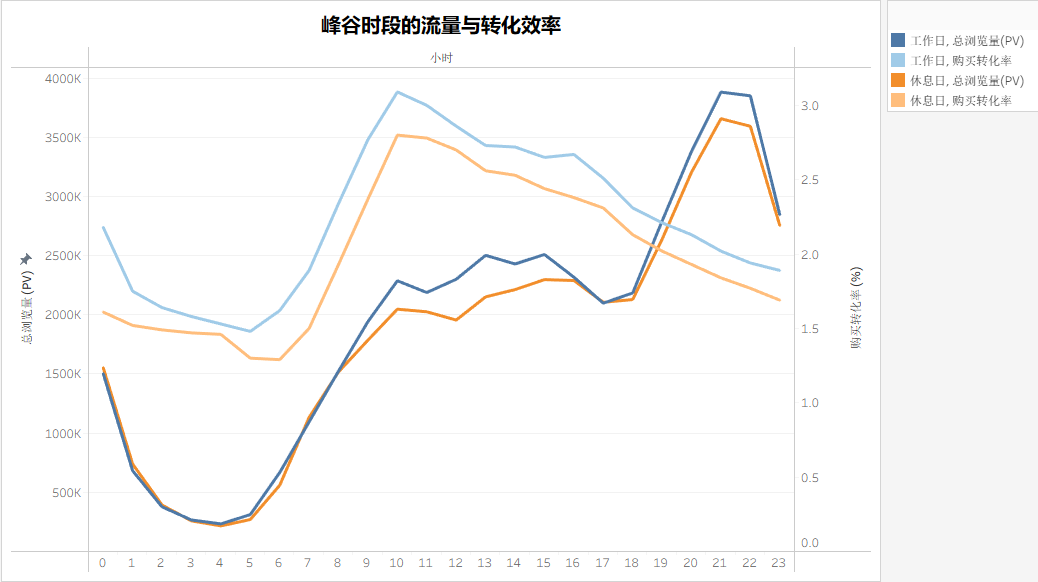

In [13]:
display(Image(filename='问题3.png'))

流量的峰值在晚上21点，工作日和休息日均是如此。建议在这个时间端集中进行品牌宣传或进行高曝光活动。<br><br>
凌晨4点附近是流量最低点。这个时间段适合进行系统维护，数据备份和非关键功能的部署。<br><br>

转化效率的峰值在上午10点，这段时间的用户可能是目的性最强的。建议将高价值，高毛利的商品进行推荐。 <br><br>
虽然流量的峰值在晚上21点，但是晚间21点的转化率较低，购买意愿较弱。建议减少对转化率要求高的活动，可以转为品牌曝光和加购收藏的引导。

# 问题四：

RFM模型：<br><br>
Recency (R): how recently the user performed a key action (e.g. purchase, add to cart, etc)
- R值计算的是用户最近一次执行关键操作的时间, 在我们的问题中关键操作为购买。当用户R的值越小，说明该用户离最近购买时间越近，活跃度越高。

Frequency (F): how often the user performs a action.
- F值计算的是用户执行一种操作（比如购买）的频率。F越大，用户购买次数越多，价值越高。

Monetary (M): how much money the user spent (can be total or average spent)
- 由于这数据集中没有价格相关的数据，我们舍弃M值的计算。

In [25]:
query_RFM = """With buy_cust_data AS(
    Select user_id, max(activity_time) as lastest_purchase_date, count(*) as purchase_frequency
    From user_behavior_data
    Where behavior_type = 'buy'
    Group by user_id
), 
RFM_scores AS(      -- 计算R和F值
Select 
    user_id,
    Round(julianday('2017-12-03 23:59:59') - julianday(lastest_purchase_date),2) as recency,
    purchase_frequency as frequency
From buy_cust_data
Order by recency ASC, frequency DESC
),
Ranked_RFM AS(      --  打分
Select
    user_id,
    recency,
    frequency,
    NTILE(5) OVER (ORDER BY recency DESC) as R_score,   -- R值越小，分数越高
    NTILE(5) OVER (ORDER BY frequency ASC) as F_score   -- F值越大，分数越高
From RFM_scores
)
Select      -- 划分用户群体
    user_id,
    recency,
    frequency,
    R_score,
    F_score,
    Case
        When R_score >=4 and F_score >=4 then '重要价值用户/忠诚客户'
        When R_score >=4 and F_score between 1 and 2 then '潜力用户/新用户'
        When R_score = 3 then '需关注用户'
        When R_score between 1 and 2 and F_score >=4 then '重要保持用户'
        When R_score between 1 and 2 and F_score =3 then '一般挽留用户'
        Else '低价值/流失客户'    -- R = 1-2 and F = 1-2
    End as user_Category
From Ranked_RFM
"""

RFM_profile = pd.read_sql_query(query_RFM, conn)
RFM_profile

,user_id,recency,frequency,R_score,F_score,user_Category
0,33413,9.0,1,1,2,低价值/流失客户
1,35015,9.0,1,1,2,低价值/流失客户
2,38184,9.0,1,1,2,低价值/流失客户
3,40193,9.0,1,1,2,低价值/流失客户
4,45489,9.0,1,1,2,低价值/流失客户
...,...,...,...,...,...,...
672399,244049,0.0,32,5,5,重要价值用户/忠诚客户
672400,507808,0.0,34,5,5,重要价值用户/忠诚客户
672401,313229,0.0,45,5,5,重要价值用户/忠诚客户
672402,907690,0.0,56,5,5,重要价值用户/忠诚客户


用户划分参考： https://www.spsspro.com/help/rfm/#_3-%E6%A0%B9%E6%8D%AE%E7%94%A8%E6%88%B7%E7%B1%BB%E5%9E%8B%E8%AE%BE%E5%AE%9A%E8%90%A5%E9%94%80%E7%AD%96%E7%95%A5

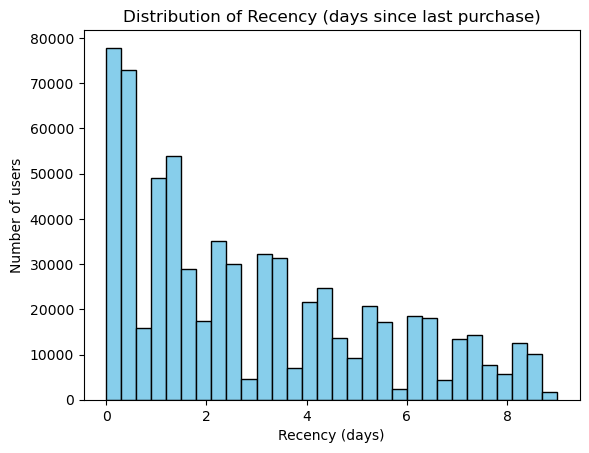

In [17]:
plt.hist(RFM_profile['recency'], bins=30, color='skyblue', edgecolor='black')

plt.title('Distribution of Recency (days since last purchase)')
plt.xlabel('Recency (days)')
plt.ylabel('Number of users')
plt.show()


In [18]:
RFM_profile['recency'].describe()

count    672404.000000
mean          2.907192
std           2.433091
min           0.000000
25%           0.940000
50%           2.260000
75%           4.520000
max           9.000000
Name: recency, dtype: float64

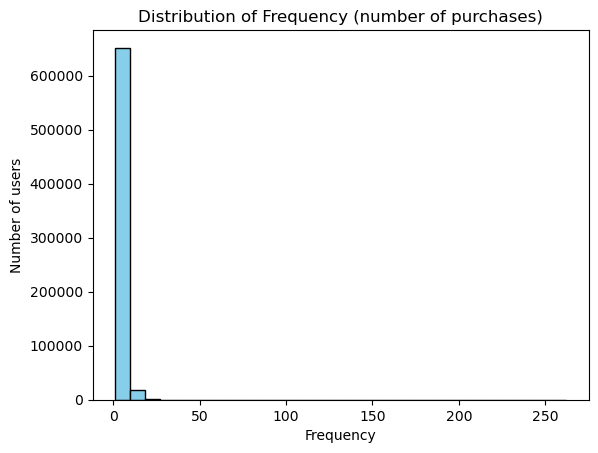

In [19]:
plt.hist(RFM_profile['frequency'], bins=30, color='skyblue', edgecolor='black')

plt.title('Distribution of Frequency (number of purchases)')
plt.xlabel('Frequency')
plt.ylabel('Number of users')
plt.show()


In [20]:
RFM_profile['frequency'].describe()

count    672404.000000
mean          2.997958
std           2.894739
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         262.000000
Name: frequency, dtype: float64

75%的用户的都只有4个或者更少的购买，大部分用户的数据是合理的。我们注意到最高值为262，这在一个只有9天的数据集中262次购买是不大合理的。

In [21]:
RFM_profile[RFM_profile['frequency'] > 100]['frequency'].value_counts()

frequency
159    1
118    1
112    1
262    1
131    1
109    1
177    1
110    1
Name: count, dtype: int64

虽然这些值不是很合理但是数量不算很多，先保留，不会影响打分机制。

解析：

| 用户类型 | 用户 RFM 特征 (R/F Score, 5分制) | 营销策略 |
| :--- | :--- | :--- |
| **重要价值用户/忠诚客户** | R $\in \{4, 5\}$, F $\in \{3, 4, 5\}$ (R高, F高) | **延长用户忠诚时间**，提供 VIP 服务、专属活动或永久折扣等有荣誉感的营销策略。 |
| **新客户/潜力客户** | R $\in \{4, 5\}$, F $\in \{1, 2\}$ (R高, F低) | **刺激用户进行复购**，增加对品牌的忠诚。定期发送新品、爆款、折扣等信息，提供新手教程。 |
| **需关注用户** | R $= 3$, F $\in \{1, 2, 3, 4, 5\}$ (R中) | **处于流失边缘的客户**，需要主动联系防止流失。推送促销和个性化推荐，或主动关怀产品使用情况。 |
| **重要保持用户** | R $\in \{1, 2\}$, F $\in \{4, 5\}$ (R低, F高) | **高价值即将流失的客户**，需大力度挽回。通过电话沟通、发送大额优惠券或推出买一送一等较大让利活动进行唤回。 |
| **一般挽留用户** | R $\in \{1, 2\}$, F $= 3$ (R低, F中) | **有潜在价值但正在流失的客户**。可使用中等成本进行尝试性触达，例如发送小额定向优惠券，根据历史行为进行个性化推荐。 |
| **低价值/流失客户** | R $\in \{1, 2\}$, F $\in \{1, 2\}$ (R低, F低) | **用户已处于流失阶段**，可不做营销，或花费较低成本进行尝试触达，减少营销资源的浪费。 |

In [40]:
RFM_profile.to_csv('RFM_user_profile.csv')

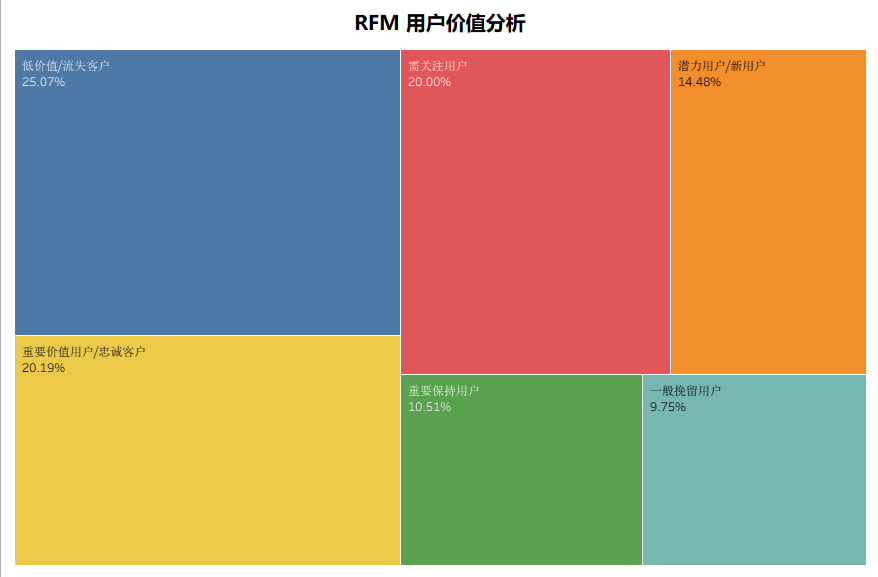

In [10]:
display(Image(filename='问题4.png'))

# 问题五：

In [7]:
query_5= """
Select 
    category_id,
    sum(case when behavior_type = 'pv' THEN 1 ELSE 0 END) AS total_pv,
    count(distinct case when behavior_type = 'pv' THEN user_id END) AS total_uv,
    sum(case when behavior_type = 'buy' THEN 1 ELSE 0 END) AS total_buy,
    count(distinct case when behavior_type = 'buy' THEN user_id END) AS unique_buy,
    round(sum(case when behavior_type = 'buy' THEN 1 ELSE 0 END) * 1.0 / count(distinct case when behavior_type = 'buy' THEN user_id END), 2) as buy_freq,
    round(100.0 * count(distinct case when behavior_type = 'buy' THEN user_id END) / count(distinct case when behavior_type = 'pv' THEN user_id END), 2) as uv_to_buy_ratio
FROM user_behavior_data
group by category_id
order by total_buy DESC
"""
category_performance = pd.read_sql_query(query_5, conn)
category_performance

,category_id,total_pv,total_uv,total_buy,unique_buy,buy_freq,uv_to_buy_ratio
0,1464116,683641,170789,34591,29953,1.15,17.54
1,2735466,1115651,255222,33730,28759,1.17,11.27
2,2885642,954553,148345,31844,27118,1.17,18.28
3,4145813,3150716,368450,31658,27529,1.15,7.47
4,4756105,4477682,410410,28258,23754,1.19,5.79
...,...,...,...,...,...,...,...
9432,7031,1,1,0,0,NaN,0.00
9433,6991,132,85,0,0,NaN,0.00
9434,5260,4,3,0,0,NaN,0.00
9435,1147,1,1,0,0,NaN,0.00


运营建议：<br><br>
将新增预算主要投入到 $2885642$ 和 $1464116$ 品类, 并用作拉新主推，以保证新用户拥有良好的首次购买体验。